In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import env.game as game

import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from itertools import count
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque
from itertools import count
import time

In [2]:
env_game = game.Game()
ob = env_game.reset()

In [3]:
from IPython.display import clear_output

def show_progress(rewards_batch, loss_batch, reward_range=[50, 5000]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    #threshold = np.percentile(rewards_batch, percentile)
    #log.append([mean_reward, threshold])

    clear_output(True)
    #print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(rewards_batch, label="Average reward")
    #plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(loss_batch, label="Average loss")
    #plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()
    #plt.hist(rewards_batch, range=reward_range)
    #plt.vlines(
    #    [np.percentile(rewards_batch, percentile)],
    ##    [0],
    #   [100],
    #    label="percentile",
    #    color="red",
    #)
    #plt.legend()
    #plt.grid()

    plt.show()


In [4]:
import torch
import numpy as np

# Define the function to encode the state of the 2048 game board
import torch
import numpy as np

def encode_board(board):
    board = board.flatten()
    max_power = 20  # Maximum power of 2 that can be represented
    num_classes = max_power + 1  # Including 0
    
    # Compute the log2 of the board values where board > 0, set the rest to 0
    powers = np.zeros_like(board, dtype=int)
    non_zero_indices = board > 0
    powers[non_zero_indices] = np.log2(board[non_zero_indices]).astype(int)
    
    # One-hot encode the powers array
    one_hot_encoded = np.eye(num_classes)[powers]
    
    # Convert to tensor
    one_hot_encoded_tensor = torch.tensor(one_hot_encoded, dtype=torch.float32)
    
    # Reshape to 4x4x21
    one_hot_encoded_tensor = one_hot_encoded_tensor.view(4, 4, num_classes)
    
    return one_hot_encoded_tensor


# Example usage:
board = np.array([[2, 4, 0, 2],
                  [8, 0, 16, 32],
                  [2, 4, 128, 0],
                  [256, 0, 1024, 2048]])

encoded_board = encode_board(board)
print(encoded_board.shape)  # Should print (16, 21) indicating 16 tiles and 21 one-hot encoded features per tile


torch.Size([4, 4, 21])


In [33]:
# Assuming you have an environment class 'Env' as described
class Env:
    def __init__(self, env_f):
        self.env = env_f
        
    def action(self, a):
        next_ob, r, term = self.env.action(a)
        next_ob = np.array(next_ob)
        encoded_next_ob = encode_board(next_ob)
        return (encoded_next_ob.permute(2, 0, 1).unsqueeze(0), r, term)  # Reshape for CNN

    def reset(self):
        initial_state = self.env.reset()
        initial_state = np.array(initial_state)
        encoded_initial_state = encode_board(np.array(initial_state))
        return encoded_initial_state.permute(2, 0, 1).unsqueeze(0)  # Reshape for CNN



# Define the DQN network
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=21, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # After flattening from the conv layers
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 64)
        self.fc6 = nn.Linear(64, 4)  # Output layer (assuming 4 possible actions)
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, x):
        # Apply the convolutional layers with ReLU activations
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Flatten the tensor for the fully connected layers
        x = x.view(x.size(0), -1)
        
        # Apply the fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        
        # Output layer (raw scores for each action)
        x = self.fc6(x)
        
        return x

class TransformerDQN(nn.Module):
    def __init__(self, num_tiles=21, d_model=64, nhead=2, num_layers=2, dim_feedforward=64):
        super(TransformerDQN, self).__init__()

        # Positional encoding for the 4x4 grid
        self.positional_encoding = nn.Parameter(torch.zeros(16, d_model))

        # Linear projection of the input one-hot vectors to the model dimension
        self.input_proj = nn.Linear(num_tiles, d_model)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            batch_first=True  # Setting batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Fully connected layers after the transformer
        self.fc1 = nn.Linear(16 * d_model, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 4)  # Output layer for Q-values
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        batch_size = x.size(0)
        
        # Reshape the input tensor to shape (batch_size, 16, 21)
        x = x.reshape(batch_size, 21, -1)
        x = x.transpose(1, 2)

        # Apply the linear projection
        x = self.input_proj(x)

        # Add positional encoding
        x = x + self.positional_encoding

        # Pass through the transformer encoder (batch_first=True ensures no need for transposing)
        x = self.transformer_encoder(x)

        # Flatten the sequence output
        x = x.contiguous().view(batch_size, -1)

        # Pass through the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)

        # Output layer (raw scores for each action)
        x = self.fc6(x)

        return x



In [34]:
# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.999
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 200000
TARGET_UPDATE = 30
MEMORY_SIZE = 50000
LR = 1e-4

class ExperienceReplay:
    def __init__(self, capacity):
        self.pointer = 0
        self.capacity = capacity
        self.states = torch.zeros((capacity, 21, 4, 4), device='cuda')
        self.actions = torch.zeros((capacity, 1), dtype=torch.int64, device='cuda')
        self.next_states = torch.zeros_like(self.states, device='cuda')
        self.rewards = torch.zeros((capacity, 1), device='cuda')
        self.dones = torch.zeros((capacity, 1), dtype=torch.int64, device='cuda')

    def push(self, s, a, r, s_new, done):
        tar_idx = self.pointer % self.capacity
        self.states[tar_idx] = s
        self.actions[tar_idx] = a
        self.rewards[tar_idx] = r
        self.next_states[tar_idx] = s_new
        self.dones[tar_idx] = done
        self.pointer += 1

    def sample(self, batch_size):
        perm = torch.randperm(len(self))
        tar_idxes = perm[:batch_size]
        return (
            self.states[tar_idxes],
            self.actions[tar_idxes],
            self.rewards[tar_idxes],
            self.next_states[tar_idxes],
            self.dones[tar_idxes],
        )

    def __len__(self):
        return min(self.pointer, self.capacity)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize environment, networks, optimizer, and memory
env = Env(env_game) #gym.make("CartPole-v1")
policy_net = TransformerDQN().to(device)
target_net = TransformerDQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, weight_decay=1e-5)
memory = ExperienceReplay(MEMORY_SIZE)

In [35]:
batch_mem = 0

In [38]:
steps_done = 0

def select_action(state, epsilon):
    global steps_done
    sample = random.random()
    steps_done += 1
    if sample > epsilon:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(4)]], dtype=torch.long, device=device)

def optimize_model():
    global dt0
    global dt1

    
    if len(memory) < BATCH_SIZE:
        return 0
    t0 = time.time()
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = memory.sample(BATCH_SIZE)

    Q_s = policy_net(state_batch).gather(1, action_batch)
    with torch.no_grad():
        # double dqn
        best_actions = policy_net(next_state_batch).max(1)[1].unsqueeze(1) 
        Q_next = target_net(next_state_batch).gather(1, best_actions) * (1-done_batch)
        #Q_next = target_net(next_state_batch).max(1)[0].unsqueeze(1).detach()

    target = reward_batch + GAMMA * Q_next
    loss = F.mse_loss(Q_s, target)
    dt0 += time.time() - t0

    t0 = time.time()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    dt1 += time.time() - t0
    return loss.item()

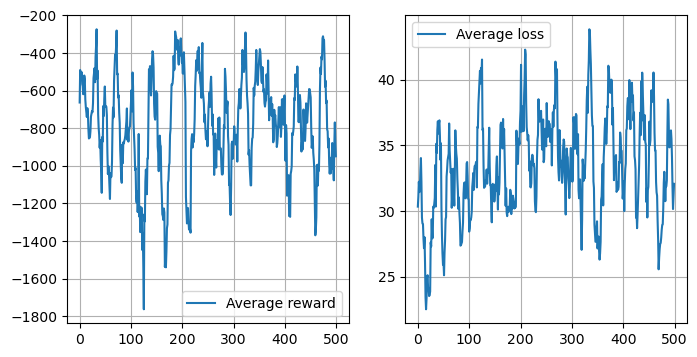

In [ ]:
# Main training loop
num_episodes = 20000
episode_durations = []
rewards = []
mean_rewards = []
losses = []
mean_losses = []
epsilon = EPSILON_START
dt0 = 0
dt1 = 0
for i_episode in range(num_episodes):
    state = torch.tensor(env.reset(), dtype=torch.float32, device=device)
    total_reward = 0
    total_loss = 0

    for t in count():
        #print(state.shape)
        epsilon = max(epsilon * 0.99999, EPSILON_END)
        action = select_action(state, epsilon)
        
        next_ob, reward, done = env.action(action.item())
        total_reward += reward

        reward = torch.tensor([reward], dtype=torch.float32, device=device)
        next_state = torch.tensor(next_ob, dtype=torch.float32, device=device) if not done else None

        memory.push(state, action, reward, next_state if not done else state, done)
        state_old = state
        state = next_state
        loss = optimize_model()
        total_loss += loss
        if done:
            #print(state_old)
            episode_durations.append(t + 1)
            rewards.append(total_reward)
            losses.append(total_loss)
            mean_losses.append(np.mean(losses[-10:])/ 10000)
            mean_rewards.append(np.mean(rewards[-10:]))  # Calculate mean reward of the last 100 episodes
            break

    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    if i_episode % 10 == 0:
        show_progress(mean_rewards[-500:], mean_losses[-500:])

In [25]:
dt0

50.036020040512085

In [26]:
dt1

60.723793029785156

In [10]:
state = torch.tensor(env.reset(), dtype=torch.float32, device=device)

/tmp/ipykernel_1349306/4086458684.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(env.reset(), dtype=torch.float32, device=device)


In [13]:
state[0, :, 0, 0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], device='cuda:0')

In [ ]:
def decode_board(encoded_board):
    # encoded_board shape: [batch_size, 21, 4, 4] or [21, 4, 4] if not batched
    # First, ensure that the encoded_board is in the correct shape
    if encoded_board.dim() == 4:
        # If the input is batched, remove the batch dimension
        encoded_board = encoded_board.squeeze(0)
    
    # Permute the encoded board to shape [4, 4, 21] for easier decoding
    encoded_board = encoded_board.permute(1, 2, 0)  # Now shape is [4, 4, 21]
    
    # Get the indices of the maximum values along the last dimension (the one-hot vector dimension)
    powers = torch.argmax(encoded_board, dim=-1)
    
    # Convert the powers back to the corresponding values in the 2048 game board
    decoded_board = torch.pow(2, powers).cpu().numpy()
    
    # Replace 2^0 (which is 1) with 0 to represent empty tiles
    decoded_board[decoded_board == 1] = 0
    
    return decoded_board



In [18]:
policy_net.eval()

DQN(
  (conv1): Conv2d(21, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=4, bias=True)
)

In [17]:
decode_board(state)

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 4, 0],
       [0, 0, 2, 0]])

In [20]:
state.shape

torch.Size([1, 21, 4, 4])

In [25]:
state = env.reset()

In [26]:
for _ in range(100):
    print('State:')
    print(decode_board(state))
    action = policy_net(state.cuda()).argmax().item()
    state, reward, done = env.action(action)
    print('Reward:', reward, 'Done:', done)
    print('\n')
    if done:
        break

State:
[[0 4 0 0]
 [0 0 0 0]
 [0 0 2 0]
 [0 0 0 0]]
Reward: 0 Done: False


State:
[[4 0 0 0]
 [0 2 0 0]
 [2 0 0 0]
 [0 0 0 0]]
Reward: 0 Done: False


State:
[[4 2 0 0]
 [2 0 0 0]
 [4 0 0 0]
 [0 0 0 0]]
Reward: 0 Done: False


State:
[[0 0 4 2]
 [0 0 0 2]
 [0 0 0 4]
 [0 0 2 0]]
Reward: 4 Done: False


State:
[[0 0 4 4]
 [0 0 2 4]
 [0 2 0 0]
 [0 0 0 0]]
Reward: 8 Done: False


State:
[[0 2 4 8]
 [0 2 2 0]
 [0 0 0 0]
 [0 0 0 0]]
Reward: 4 Done: False


State:
[[2 4 4 8]
 [0 0 2 0]
 [0 0 0 0]
 [0 0 0 0]]
Reward: 8 Done: False


State:
[[2 8 8 0]
 [2 0 0 0]
 [0 2 0 0]
 [0 0 0 0]]
Reward: 16 Done: False


State:
[[ 2 16  0  0]
 [ 2  0  0  0]
 [ 2  0  0  0]
 [ 0  0  0  2]]
Reward: 4 Done: False


State:
[[ 4 16  0  2]
 [ 2  0  0  0]
 [ 0  0  2  0]
 [ 0  0  0  0]]
Reward: 0 Done: False


State:
[[ 4 16  2  0]
 [ 2  2  0  0]
 [ 2  0  0  0]
 [ 0  0  0  0]]
Reward: 4 Done: False


State:
[[ 4 16  2  0]
 [ 4  0  0  2]
 [ 2  0  0  0]
 [ 0  0  0  0]]
Reward: 8 Done: False


State:
[[ 8 16  2  2]
 

In [27]:
policy_net(state.cuda())

tensor([[2935.0625, 2907.4143, 2930.1863, 2944.1321]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [22]:
action

tensor(1, device='cuda:0')

In [13]:
s0.shape

torch.Size([1, 21, 4, 4])

In [ ]:
state = torch.tensor(env.reset(), dtype=torch.float32, device=device).unsqueeze(0)

In [22]:
state

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0.]],
       device='cuda:0')

In [23]:
policy_net(state)

tensor([[554.8129, 552.2155, 553.0561, 554.3870]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [71]:
policy_net.eval()

DQN(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=2048, bias=True)
  (fc5): Linear(in_features=2048, out_features=2048, bias=True)
  (fc6): Linear(in_features=2048, out_features=1024, bias=True)
  (fc7): Linear(in_features=1024, out_features=256, bias=True)
  (fc8): Linear(in_features=256, out_features=128, bias=True)
  (fc9): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

torch.Size([16, 21])


In [28]:
encoded_board

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [79]:
env.reset()

(array([ 0.02856593, -0.04845341, -0.00792314,  0.02017498], dtype=float32),
 {})

In [84]:
state

array([-0.02849323,  0.04839472,  0.00306607, -0.00299951], dtype=float32)

In [8]:
import gymnasium as gym

In [9]:
from gymnasium.wrappers import RecordVideo
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()
#env = preprocess_env(env)  # method with some other wrappers
env = RecordVideo(env, 'video', episode_trigger=lambda x: x == 2)
env.start_video_recorder()

for episode in range(4):
        state = env.reset()[0]
        done = False
        while not done:
            action = policy_net(torch.tensor(state, device='cuda').unsqueeze(0)).argmax().item()
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            env.render()

/home/ilya/anaconda3/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/ilya/Desktop/RL/RL_2048/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/ilya/Desktop/RL/RL_2048/video/rl-video-episode-0.mp4.
Moviepy - Writing video /home/ilya/Desktop/RL/RL_2048/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/ilya/Desktop/RL/RL_2048/video/rl-video-episode-0.mp4


KeyboardInterrupt: 

In [88]:
#torch.save(policy_net.state_dict(), 'policy_net.pth')

In [3]:
policy_net = DQN().to('cuda')

In [5]:
policy_net.load_state_dict(torch.load('policy_net.pth'))

/tmp/ipykernel_1167935/4165716865.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load('policy_net.pth'))


<All keys matched successfully>

In [168]:
state

tensor([[0., 2., 4., 8., 0., 0., 2., 4., 0., 2., 0., 4., 0., 0., 0., 0.]],
       device='cuda:0')

In [169]:
epsilon

0.9990004498800211

In [69]:
dt0

12.923002481460571

In [70]:
dt1

15.685814142227173